In [ ]:
#Imports necesarios para el análisis de datos
import numpy as np
import pandas as pd

#Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

#XGBoost para el modelo de clasificación
import xgboost as xgb

#Herramientas de sklearn para entrenamiento y evaluación
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter

#Se usa para guardar el modelo entrenado
import joblib

#Suprimir warnings para una salida más limpia
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Cargar el dataset de diabetes
data = pd.read_csv('../Datasets/dataset_original.csv')

In [ ]:
#Limpiar y estandarizar la columna de género
data['gender'] = data['gender'].astype(str).str.strip().str.upper()

In [ ]:
#Mostrar información general del dataset para comprobar visualmente
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
#Se recategoriza el historial de tabaquismo en grupos más simples
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'
    
data['smoking_history'] = data['smoking_history'].apply(recategorize_smoking)

In [ ]:
#Configuración del tamaño de muestra para el entrenamiento
total_samples = 5000  

#Calcular muestras por clase manteniendo proporciones 91.5% / 8.5%
class_0_samples = int(total_samples * 0.915)
class_1_samples = int(total_samples * 0.085)

#print(f"=== CONFIGURACIÓN: {total_samples} muestras totales ===")
#print(f"Clase 0 (No diabetes): {class_0_samples}")
#print(f"Clase 1 (Diabetes): {class_1_samples}")

#Crear muestra manteniendo las proporciones originales
stratified_data = pd.concat([
    data[data['diabetes'] == 0].sample(n=min(class_0_samples, len(data[data['diabetes'] == 0])), random_state=42),
    data[data['diabetes'] == 1].sample(n=min(class_1_samples, len(data[data['diabetes'] == 1])), random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

#print(f"\nDistribución final:")
#print(stratified_data['diabetes'].value_counts())
#print(f"Proporciones finales:")
#print(stratified_data['diabetes'].value_counts(normalize=True))

data = stratified_data

=== CONFIGURACIÓN: 5000 muestras totales ===
Clase 0 (No diabetes): 4575
Clase 1 (Diabetes): 425

Distribución final:
diabetes
0    4575
1     425
Name: count, dtype: int64
Proporciones finales:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [ ]:
#En esta celda se configura el preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        #Primero se estandarizan las variables numéricas
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        #Luego se codificar las variables categóricas
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [ ]:
# Calcular pesos automáticamente para balancear clases desbalanceadas
class_counts = Counter(y)
#print(f"Conteo de clases: {class_counts}")

total_samples = len(y)
weight_for_0 = total_samples / class_counts[0] 
weight_for_1 = total_samples / class_counts[1]

#En XGBoost, scale_pos_weight es el ratio que penaliza más los errores en la clase minoritaria, esto se usa porque se tienen muy pocos datos de pacientes con diabetes
scale_pos_weight = weight_for_1 / weight_for_0
#print(f"Scale pos weight calculado: {scale_pos_weight}")

#Se crea el pipeline que incluye preprocesamiento y modelo con pesos balanceados
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight))])

Conteo de clases: Counter({0: 4575, 1: 425})
Scale pos weight calculado: 10.76470588235294


In [ ]:
#Se definen los hiperparámetros para optimizar con GridSearch
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [3],
    'classifier__learning_rate': [0.001, 0.01],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
}

In [ ]:
#Se configura la búsqueda de hiperparámetros usando Cross-Validation
grid_search = GridSearchCV(clf, param_grid, cv=5)

#Aquí se dividen los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Y finalmente se entrena el modelo con los mejores hiperparámetros
grid_search.fit(X_train, y_train)

#print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


In [ ]:
#Esta celda permite guardar el modelo entrenado
model_dir = f'../Guardar_modelo/ML/Binary/'
os.makedirs(model_dir, exist_ok=True)

model_path = f'{model_dir}Binary_{total_samples}_xgboost.pkl'
joblib.dump(grid_search.best_estimator_, model_path) 

['../Guardar_modelo/ML/Binary/Binary_5000_xgboost.pkl']

Model Accuracy:  0.952
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       915
           1       0.68      0.82      0.74        85

    accuracy                           0.95      1000
   macro avg       0.83      0.89      0.86      1000
weighted avg       0.96      0.95      0.95      1000



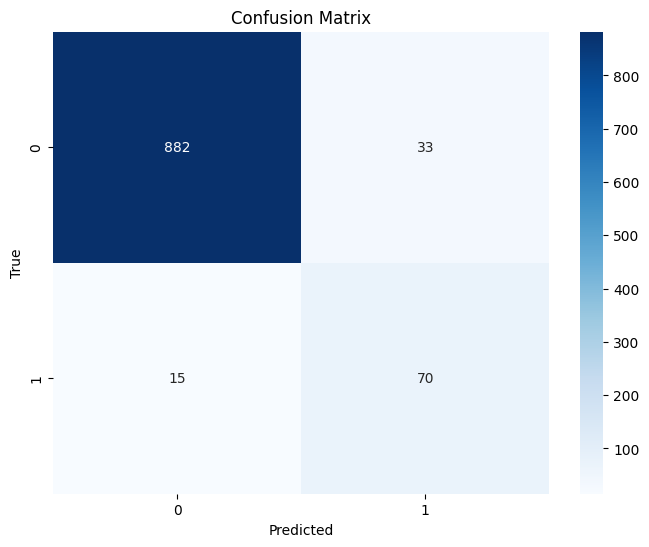

In [ ]:
#Se hacen predicciones en el conjunto de prueba para evaluar el rendimiento del modelo
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Finalmente se crea y se muestra la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()